In [1]:
%cd ../

/home/tadenoud/Git/simple-faster-rcnn-pytorch


In [2]:
CHECKPOINT_DIR = './idd_fn_detection'

import os
import numpy as np
import pickle
import h5py
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from ood_metrics import auroc, plot_roc, calc_metrics

import warnings
warnings.filterwarnings(action='once')


In [3]:
%matplotlib inline

In [4]:
def load_novelty_scores_labels(filename):
    scores, labels = [],[]
    with h5py.File(filename, 'r') as f:
        scores = f["scores"][()]
        labels = f["labels"][()]
    return scores, labels

# Draw the Chart

In [5]:
methods = [
    "softmax", 
    "odin", 
    "mahal", 
    "mahal_p", 
    "svm_fc", 
    "svm_conv",
    "svm_vahdat",
    "entropy", 
    "mi"
]

labels = [
    "Max Softmax", 
    "ODIN", 
    "Mahalanobis", 
    "Mahalanobis (w pert.)", 
    "SVM (fc)", 
    "SVM (conv)", 
    "SVM (early layer)", 
    "Predicted Entropy", 
    "Mutual Information"
]

### Kitti

In [6]:
def risk_coverage(scores, gt_labels):
    """High scores would ideally correspond to a gt_label of 1."""
    # High scores should equate to more confidence its a True Positive
    scores_ = -np.array(scores)
    gt_labels_ = np.array(gt_labels)
    scores_, gt_labels_ = np.array(sorted(zip(scores_, gt_labels_), key=lambda x: x[0])).T
    
    coverage = []
    risk = []
    for theta in scores_:
        mask = scores_ >= theta  # TODO: >= or > ? Doing >= so that risk is defined when coverage == 0
        
        # Bitwise logic operations for speed up
        mask = np.array(mask).astype(np.int)
        coverage.append(np.sum(mask))
        risk.append(np.sum(np.logical_and(gt_labels_, mask)))

        # Slow way alternative
#         coverage.append(sum(mask) / len(mask))
#         risk.append(sum(gt_labels_[mask]) / len(gt_labels_))
    
    return np.array(coverage) / len(mask), np.array(risk) / len(gt_labels)

In [7]:
%reset -f array

In [8]:
kitti_scores_labels =[load_novelty_scores_labels(
    os.path.join(CHECKPOINT_DIR,"scores_labels_kitti_val_%s.h5" % m)) for m in methods]
kitti_cr = [risk_coverage(*sl) for sl in kitti_scores_labels]

In [9]:
import matplotlib

# set figure size as a fraction of the columnwidth
columnwidth = 460.72124

def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                             using \\the\\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

In [29]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve


def draw_risk_coverage_combined(data):
    params = {
        'backend': 'Agg',
        'axes.labelsize': 10,
        'font.size': 10,
        'font.family': 'serif',
        'figure.dpi': 300
    } # extend as needed
    matplotlib.rcParams.update(params)
    max_risk = np.max(data[0][1])

    plt.figure(figsize=get_figsize(columnwidth, wf=1.0, hf=1.0))
    
    for c, r, label in data:
        plt.plot(c, r, label=label)

    plt.xlim([0.0,1.0])
    plt.ylim([0.0,max_risk])
    plt.ylabel("Risk")
    plt.xlabel("Coverage")
    plt.legend(loc='upper left')
    plt.show()
    
    
def draw_risk_coverage_separate(data):
    params = {
        'backend': 'Agg',
        'axes.labelsize': 10,
        'xtick.labelsize': 'small',
        'ytick.labelsize': 'small',
        'font.size': 10,
        'font.family': 'serif',
        'figure.dpi': 300,
        'axes.titlesize': 'medium'
    } # extend as needed
    matplotlib.rcParams.update(params)
    colors = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
    
    max_risk = np.max(data[0][1])
    plt.figure(figsize=get_figsize(columnwidth, wf=1.0, hf=1.0))
    
    for i, (c, r, label) in enumerate(data):
        ax = plt.subplot(3, 3, i+1)
        ax.plot(c, r, label=label, c=colors[i])
        ax.set(title=label, ylabel="Risk", xlabel="Coverage")
        ax.label_outer()
        
        ax.set_xticks(np.arange(0,1.2,0.2))
        ax.set_yticks(np.arange(0,1.2,0.2))
        ax.set_xlim([0.0,1.0])
        ax.set_ylim([0.0, max_risk])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax.yaxis.set_ticks([0.000,0.001,0.002,0.003, 0.004,0.005,0.006,0.007])
        
    plt.show()
    
from matplotlib.ticker import FormatStrFormatter
def draw_auroc_separate(data):
    params = {
        'backend': 'Agg',
        'axes.labelsize': 10,
        'xtick.labelsize': 'small',
        'ytick.labelsize': 'small',
        'font.size': 10,
        'font.family': 'serif',
        'figure.dpi': 300,
        'axes.titlesize': 'medium'
    } # extend as needed
    matplotlib.rcParams.update(params)
    colors = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
    
    max_risk = np.max(data[0][1])
    plt.figure(figsize=get_figsize(columnwidth, wf=1.0, hf=1.0))
    
    for i, (s, l, label) in enumerate(data):
        # Compute values for curve
        fpr, tpr, _ = roc_curve(l, s)

        # Compute AUROC
        roc_auc = auroc(s, l.astype(np.int))
        
        ax = plt.subplot(3, 3, i+1)
        ax.plot(fpr, tpr, c=colors[i])
#         ax.plot(fpr, tpr, label=label, )
        ax.set(title=label, ylabel="TPR", xlabel="FPR")
        ax.label_outer()
        ax.annotate('AUROC: %0.2f' % roc_auc, xy=(0.55,0.05), fontsize=6)
        
        ax.set_xticks(np.arange(0,1.2,0.2))
        ax.set_yticks(np.arange(0,1.2,0.2))
        ax.set_xlim([0.0,1.0])
        ax.set_ylim([0.0, max_risk])
    plt.show()

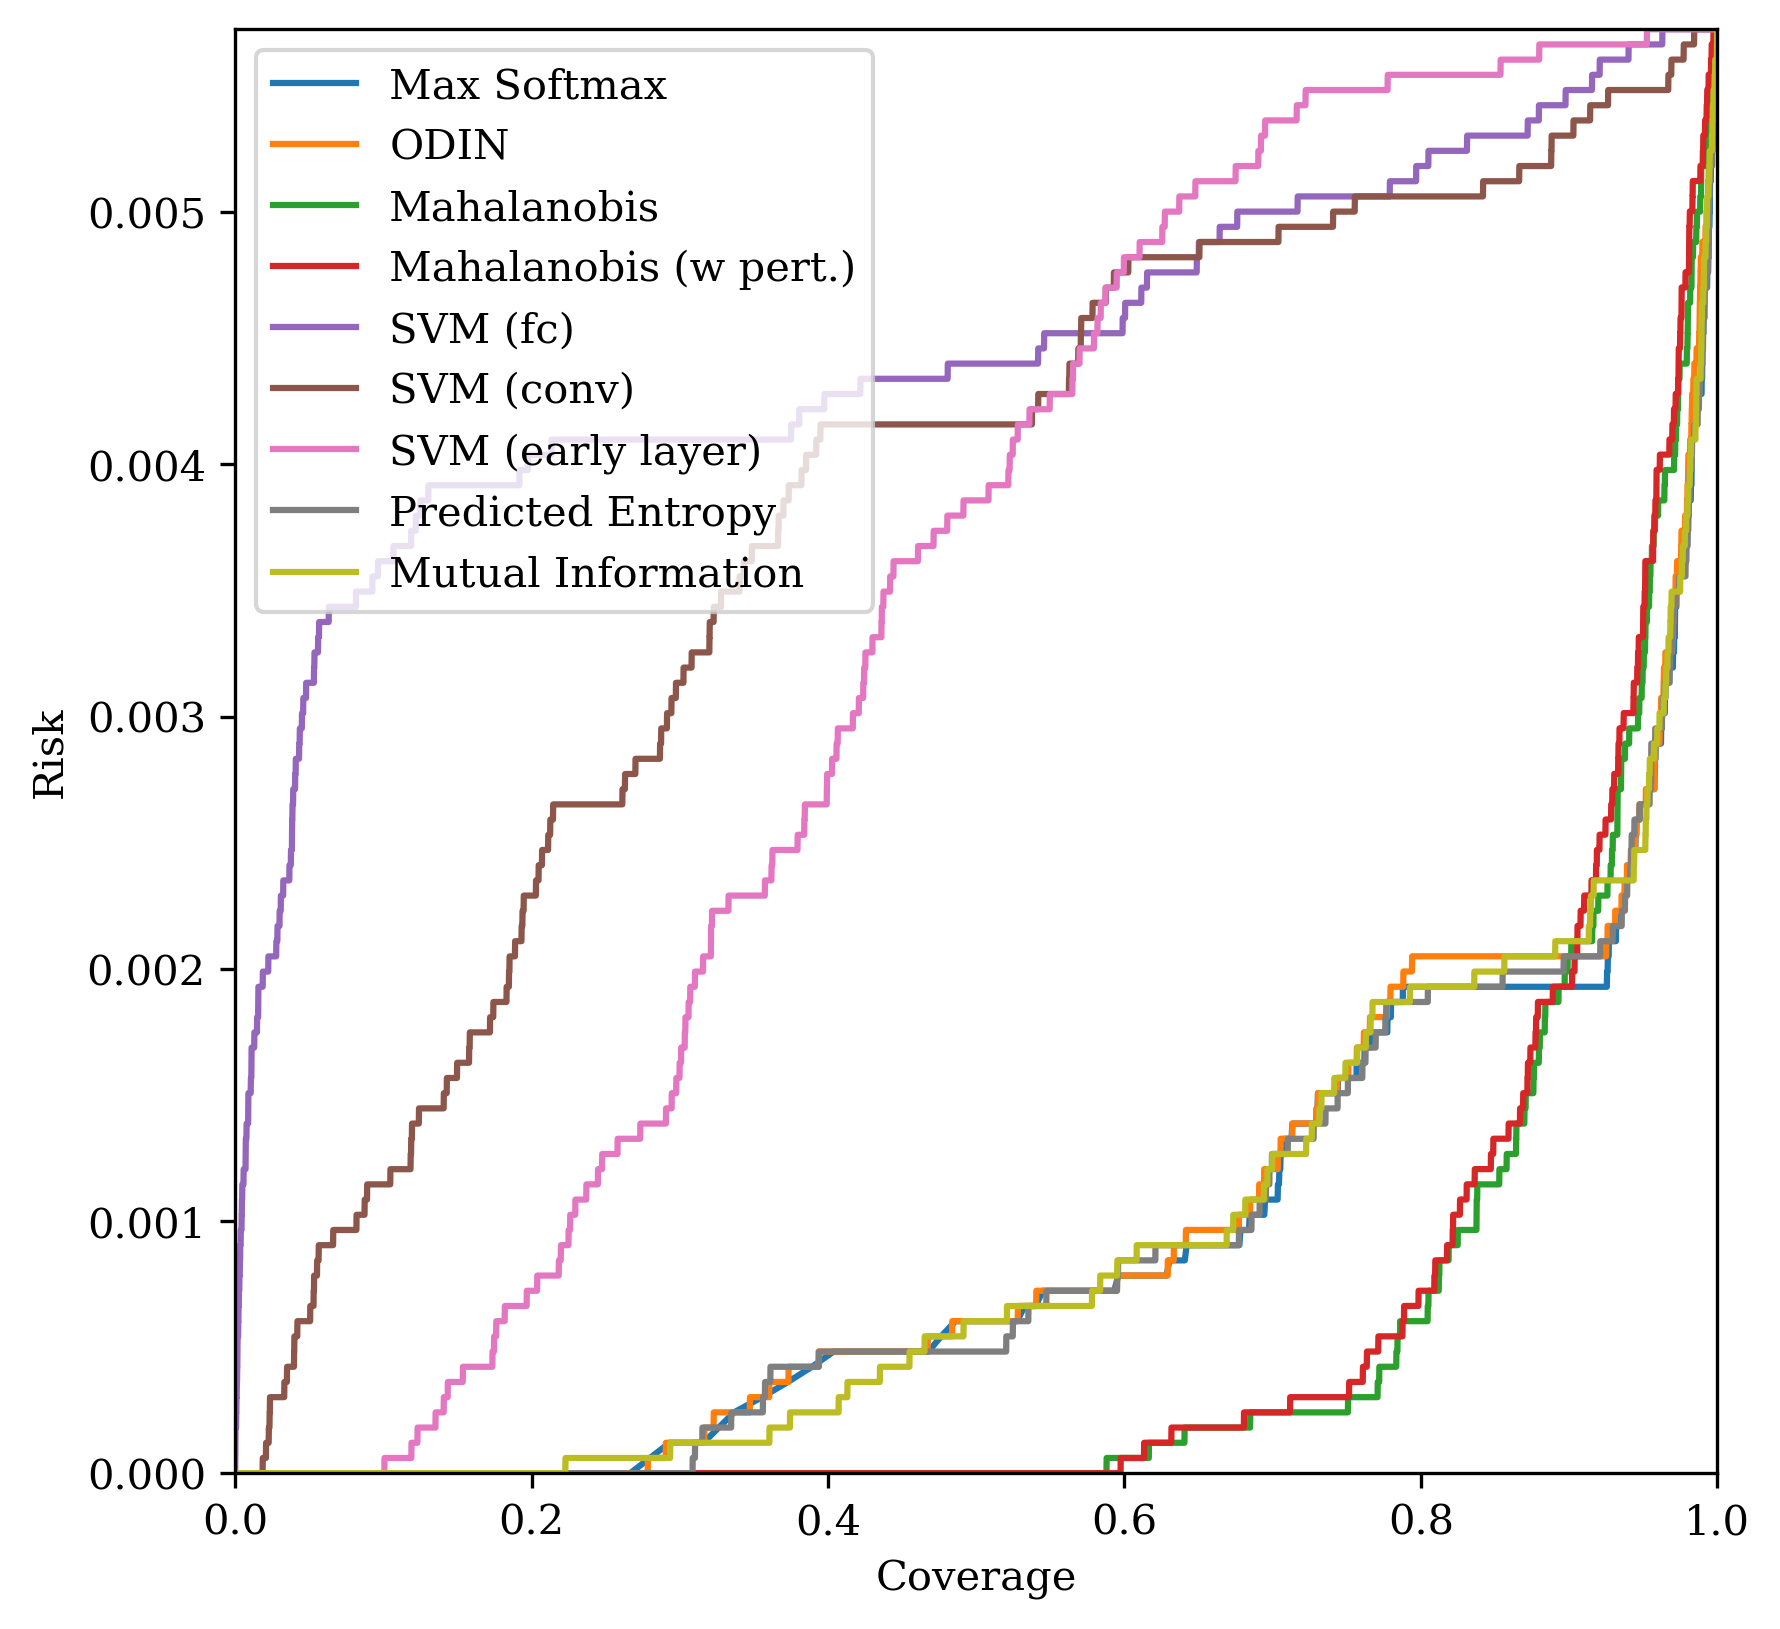

In [11]:
draw_risk_coverage_combined([(*cr, la) for cr, la in zip(kitti_cr, labels)])

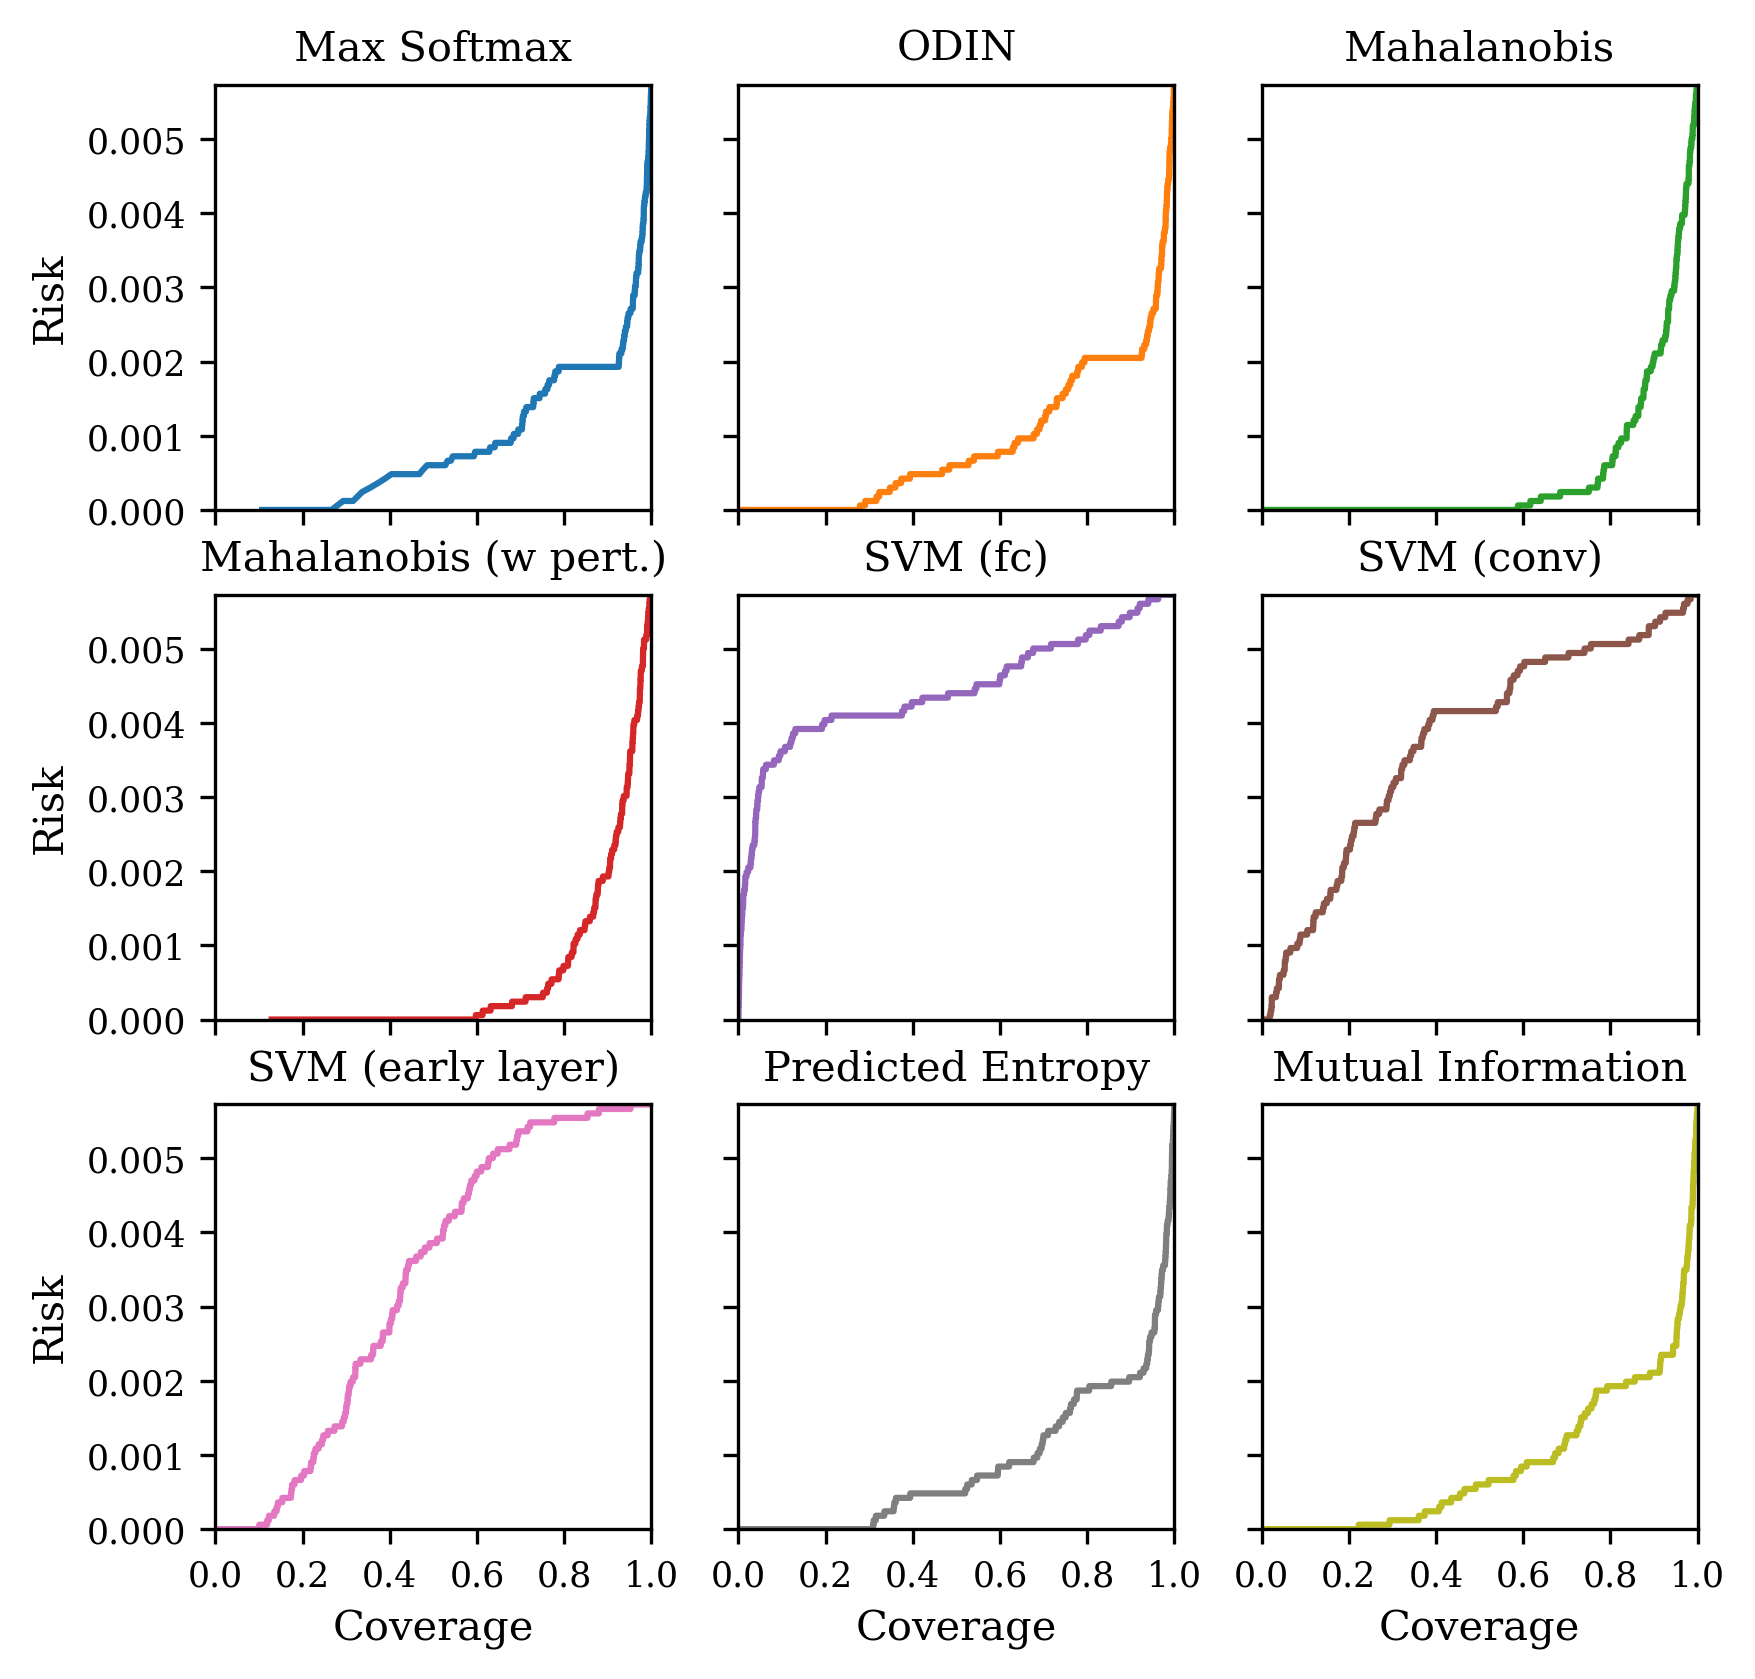

In [26]:
draw_risk_coverage_separate([(*cr, la) for cr, la in zip(kitti_cr, labels)])

### AUROC

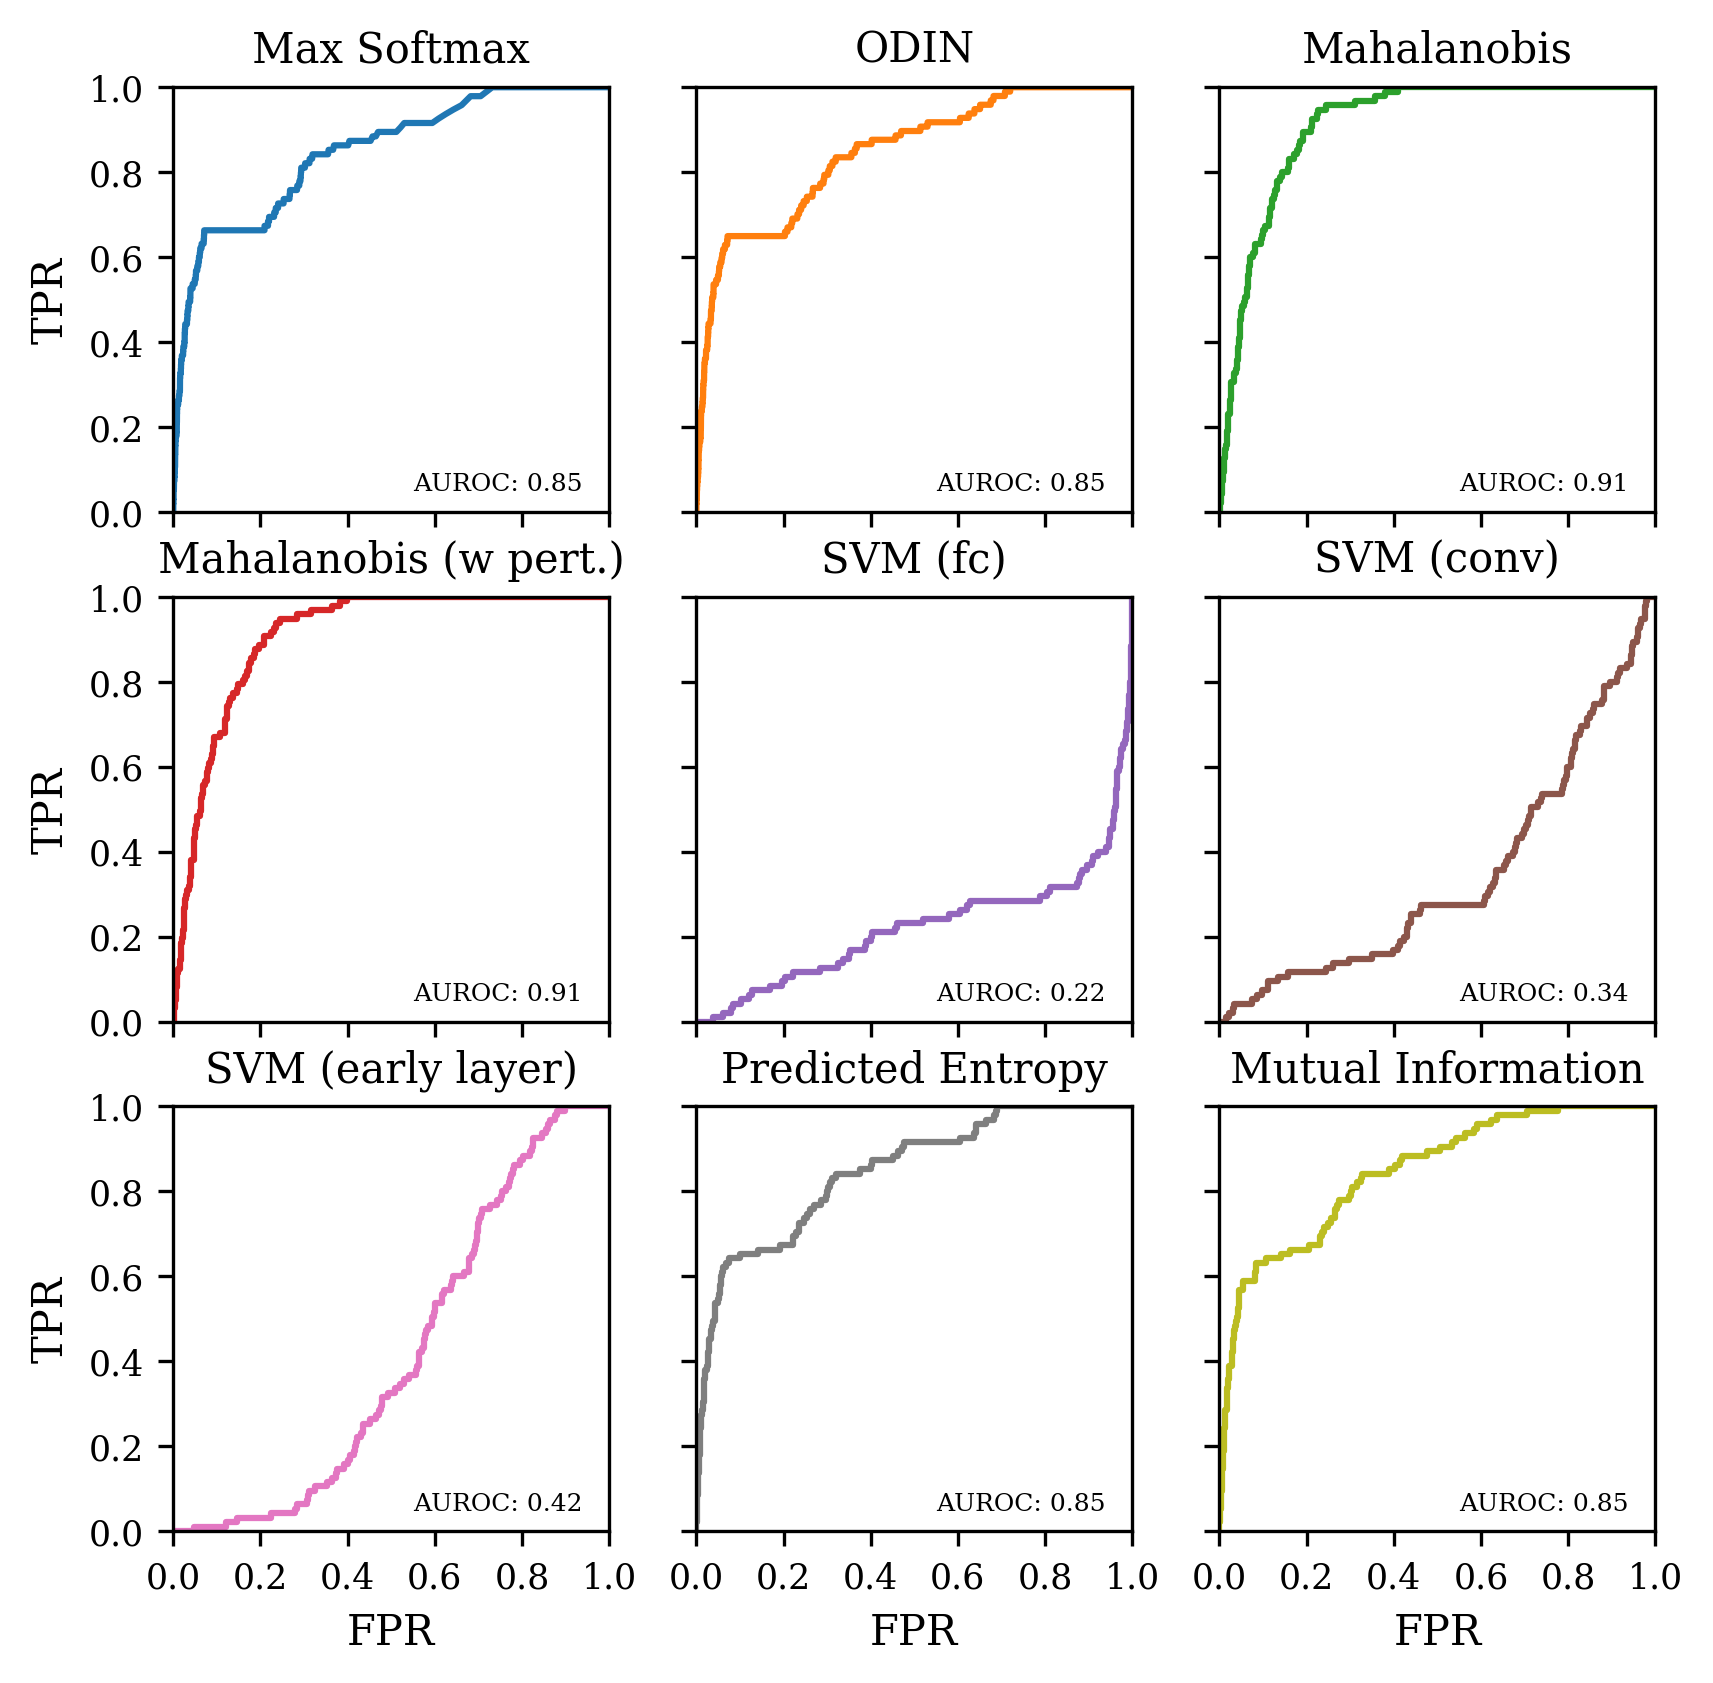

In [26]:
draw_auroc_separate([(*sl, la) for sl, la in zip(kitti_scores_labels, labels)])

### IDD

In [27]:
idd_scores_labels =[load_novelty_scores_labels(
    os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_%s.h5" % m)) for m in methods]
idd_cr = [risk_coverage(*sl) for sl in idd_scores_labels]

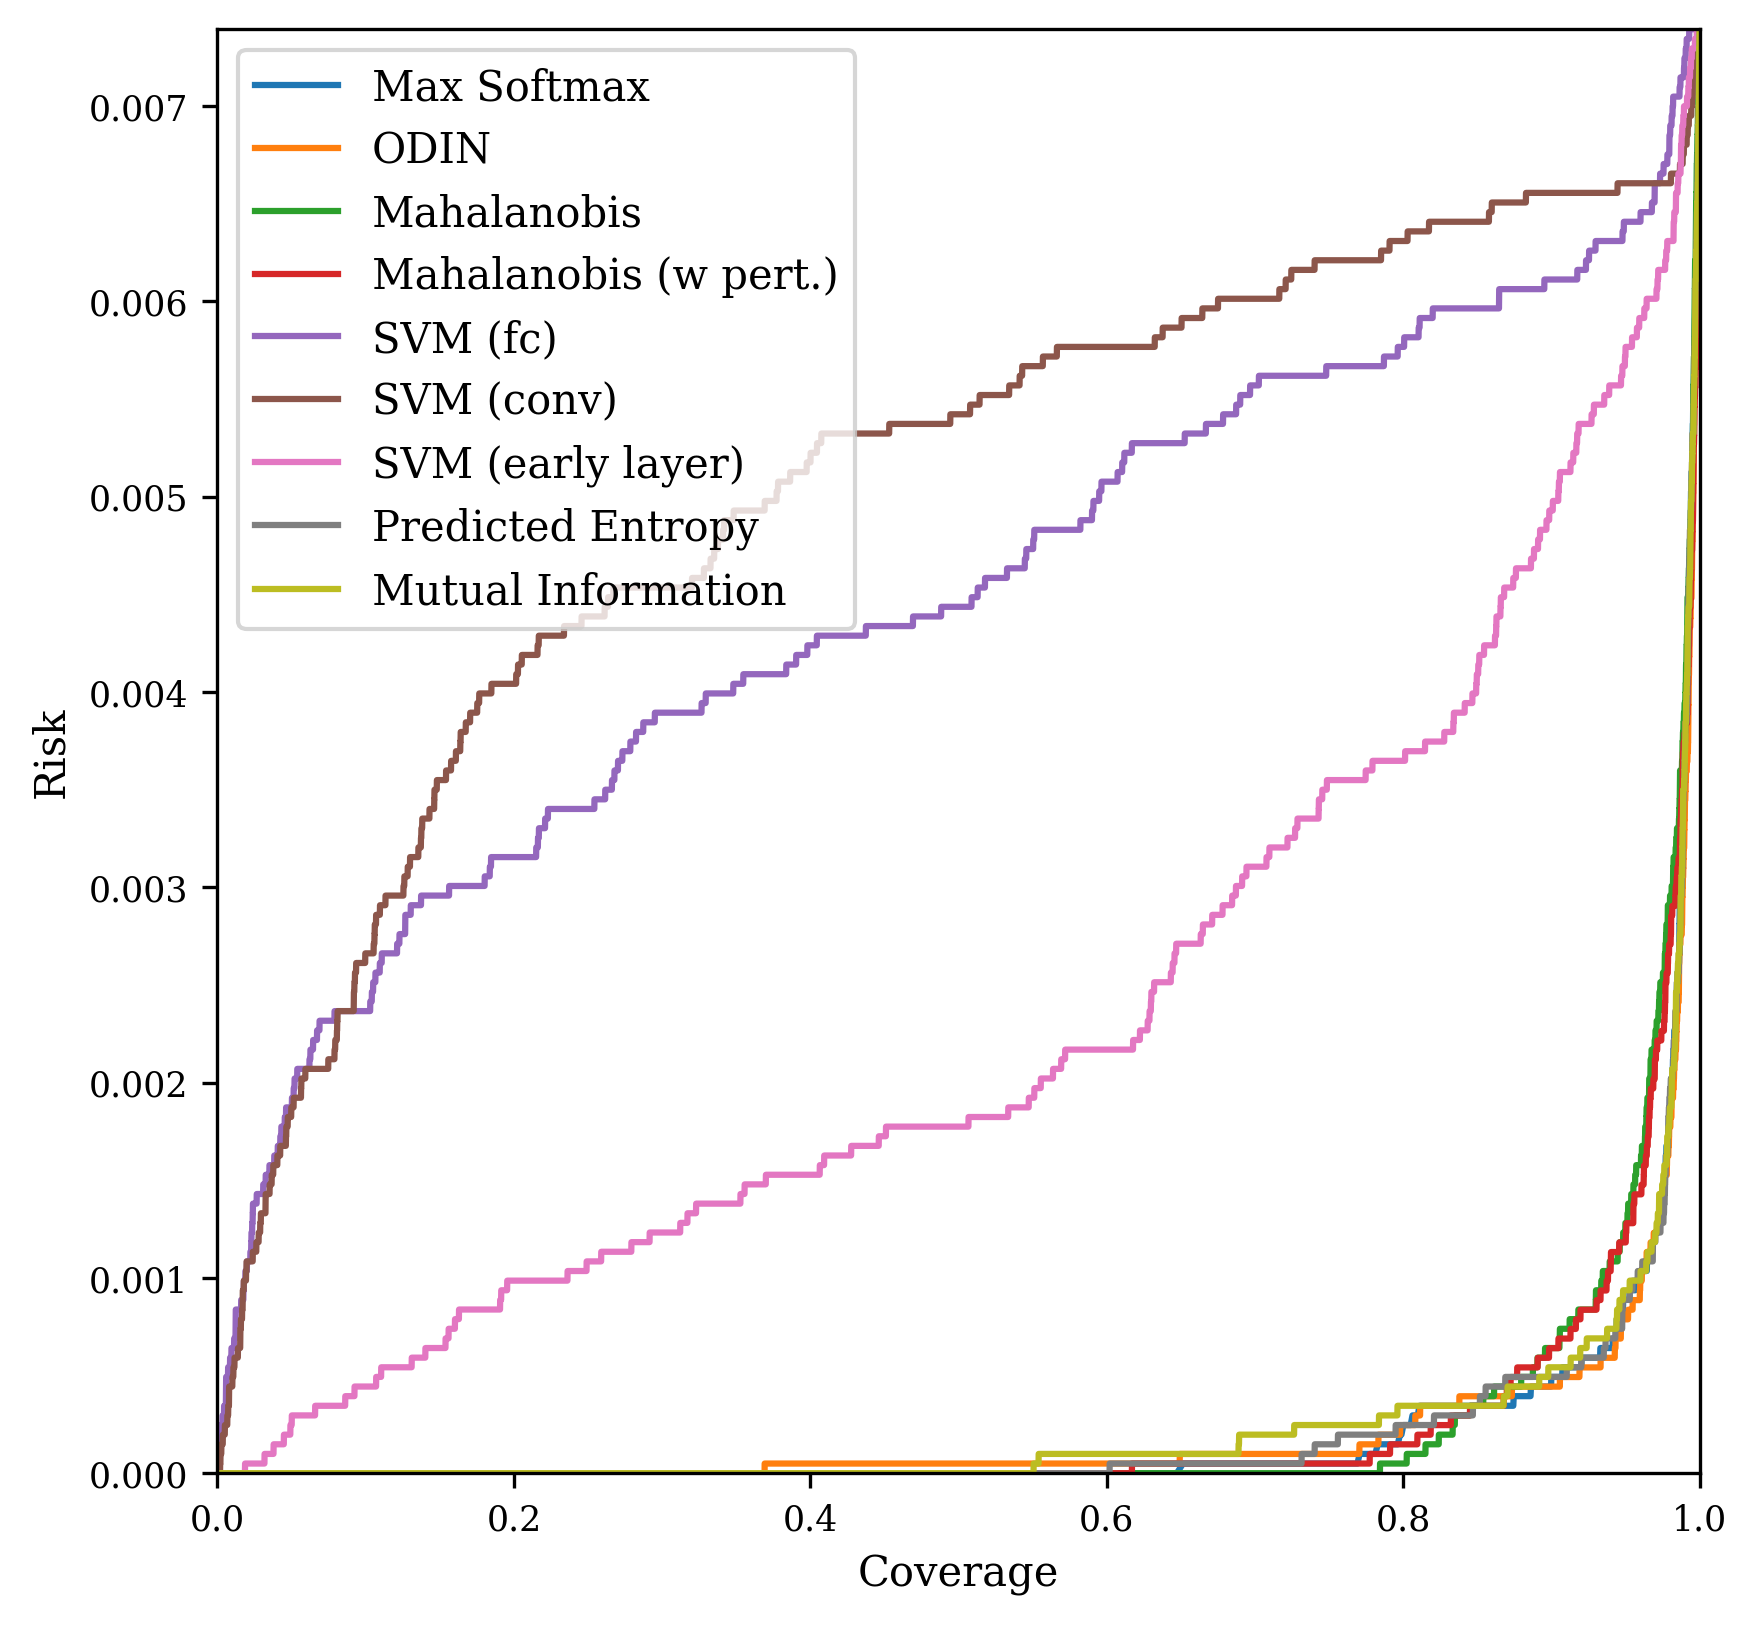

In [28]:
draw_risk_coverage_combined([(*cr, la) for cr, la in zip(idd_cr, labels)])

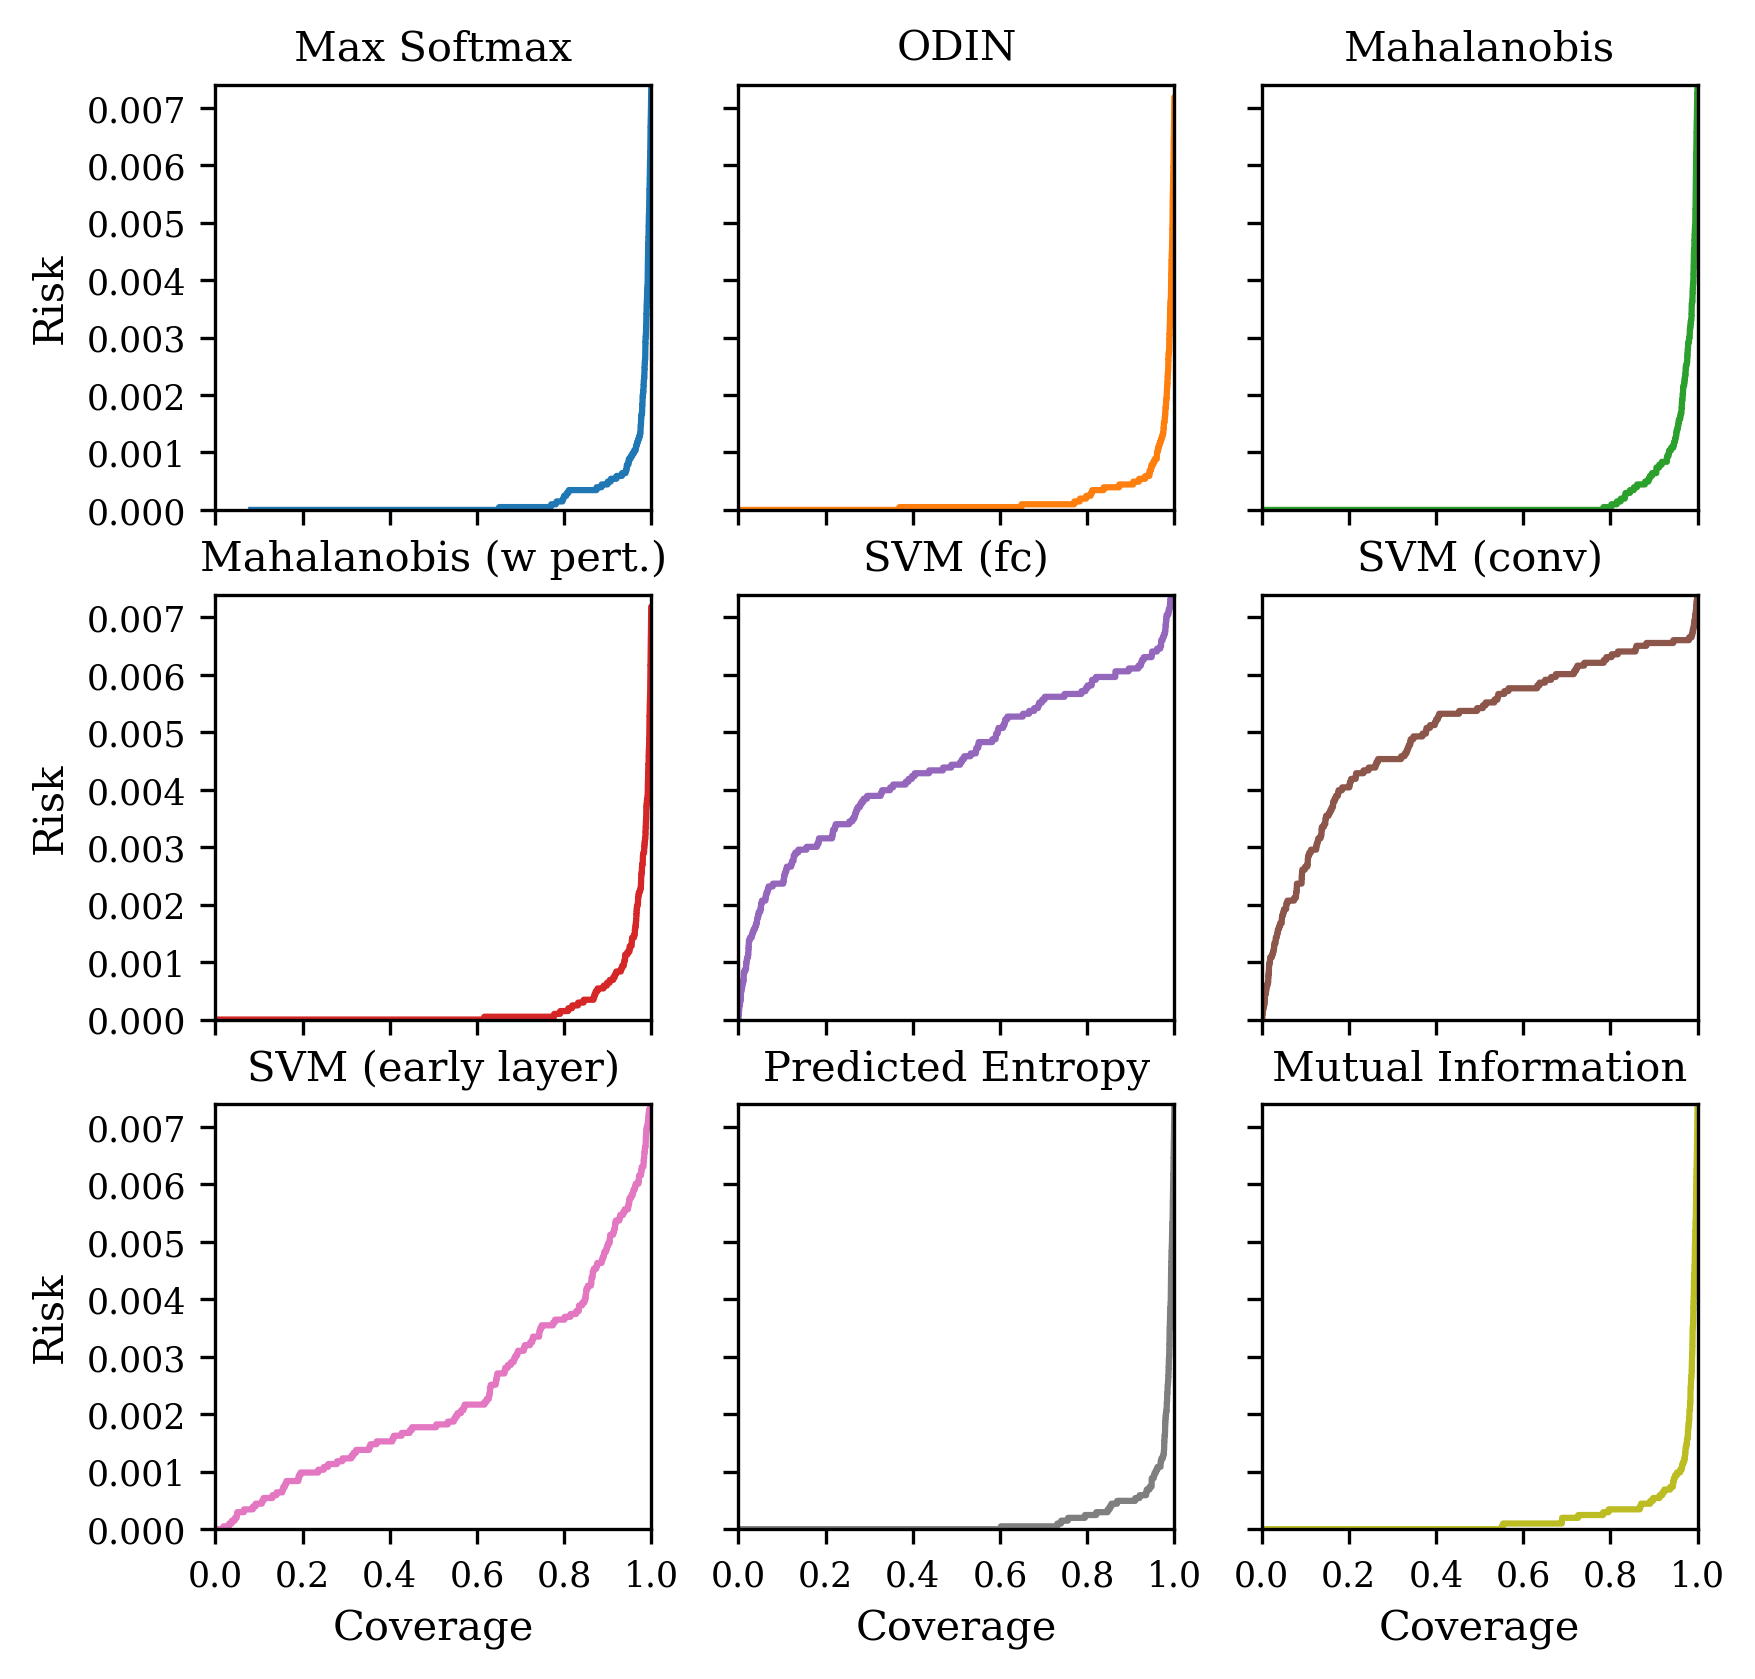

In [30]:
draw_risk_coverage_separate([(*cr, la) for cr, la in zip(idd_cr, labels)])

### AUROC

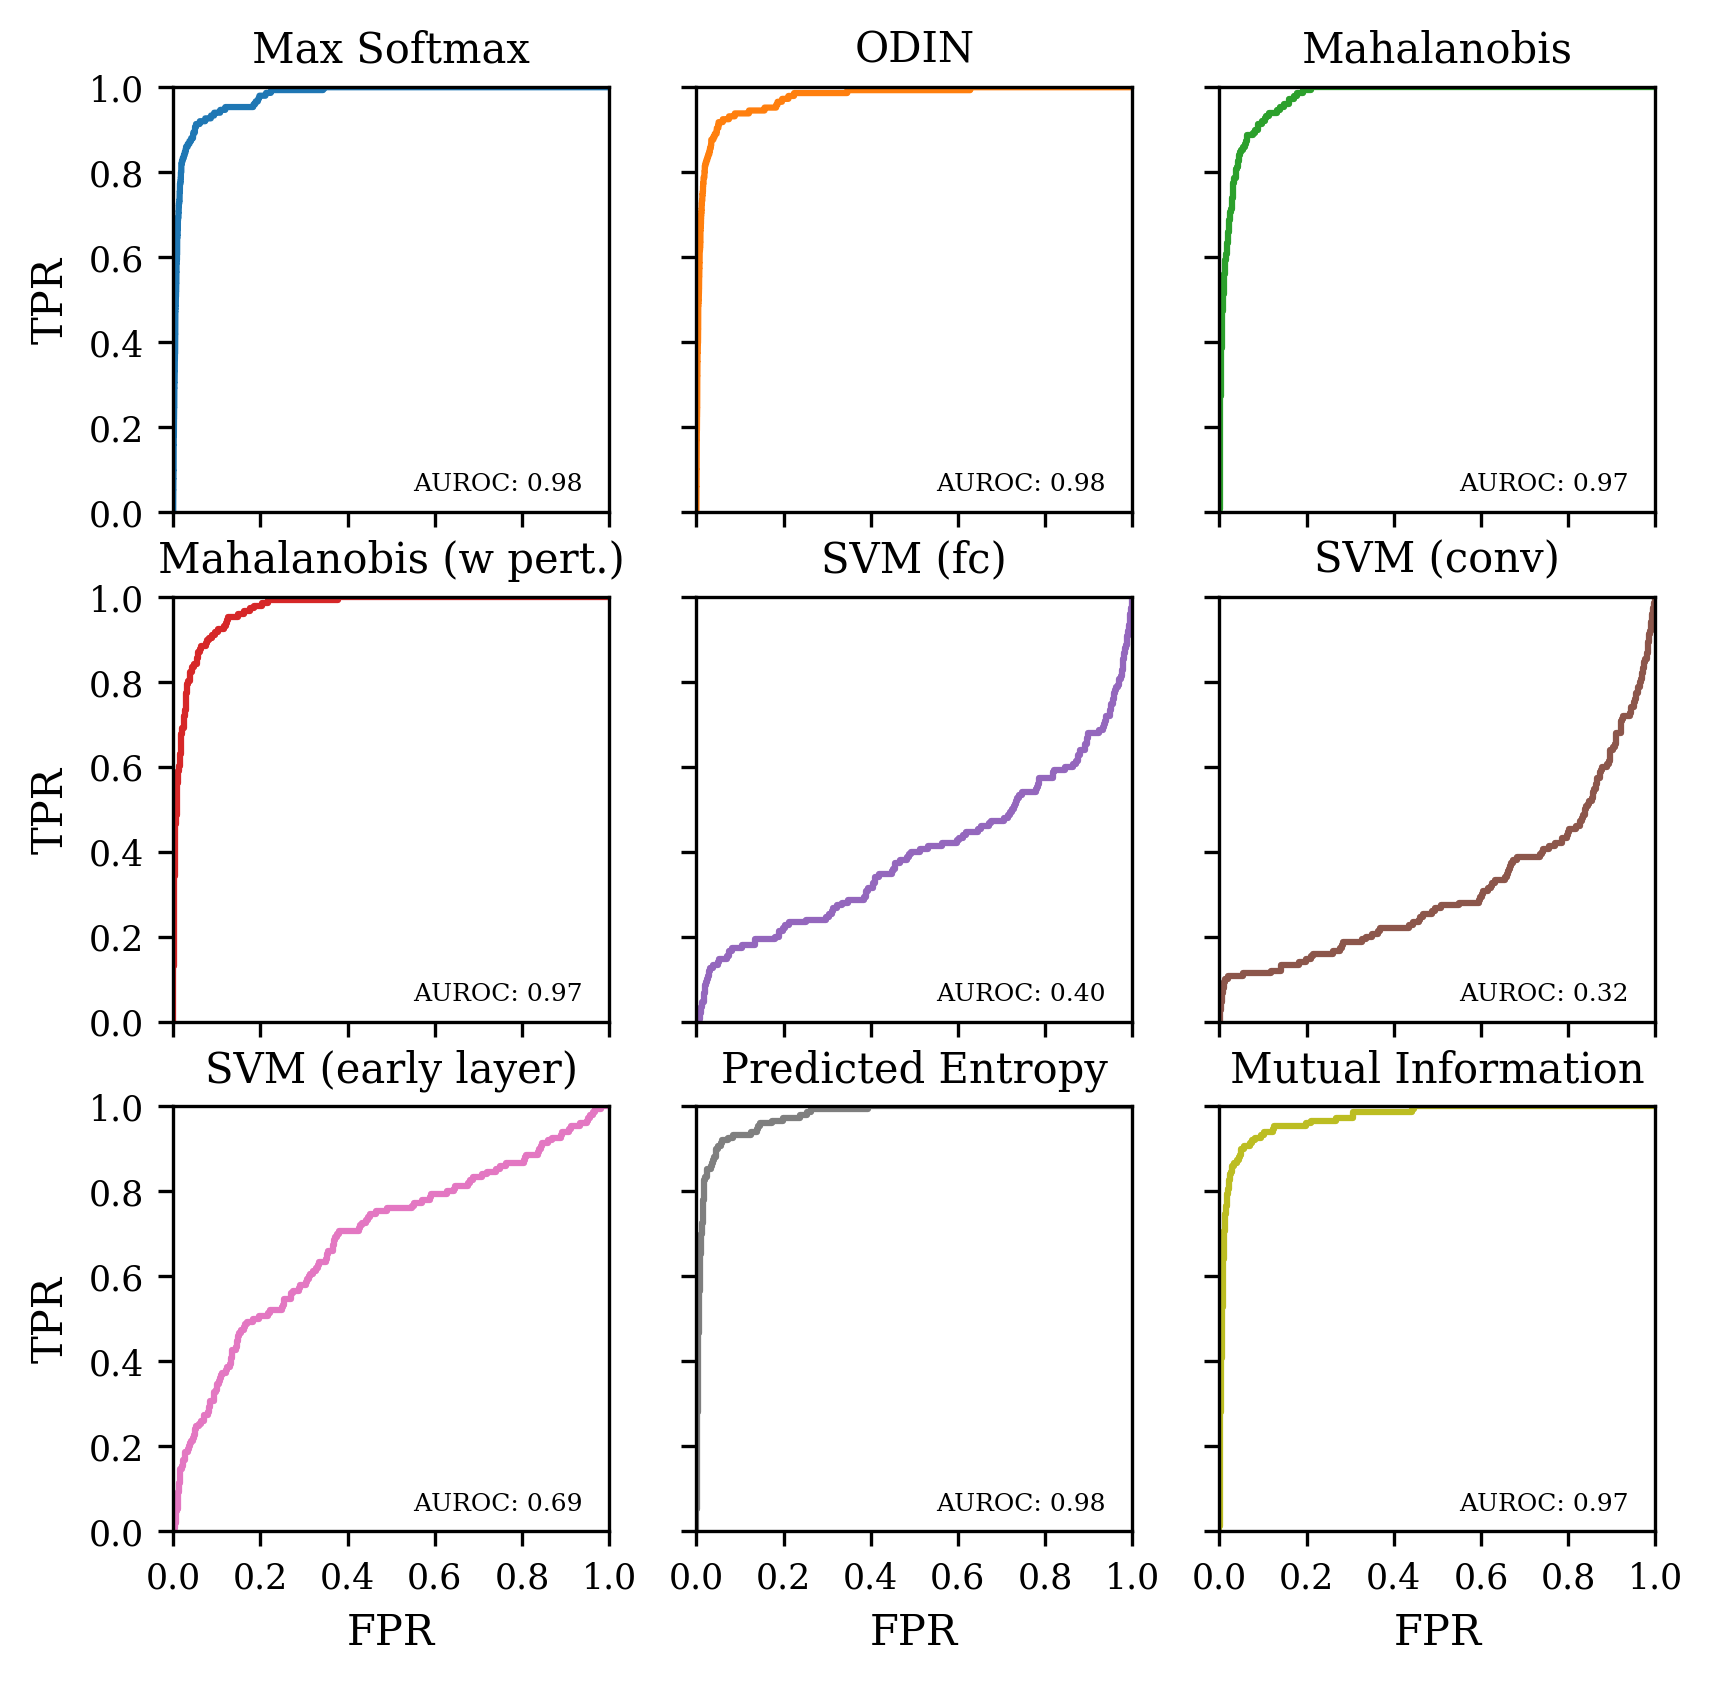

In [30]:
draw_auroc_separate([(*sl, la) for sl, la in zip(idd_scores_labels, labels)])

In [31]:
kitti_results = [calc_metrics(*sl) for sl in kitti_scores_labels]

In [32]:
for r, l in zip(kitti_results, labels):
    print(l)
    print(r)
    print()

Max Softmax
{'fpr_at_95_tpr': 0.6474421141956601, 'detection_error': 0.6581691074549509, 'auroc': 0.8481851069667137, 'aupr_out': 0.07468003519815745, 'aupr_in': 0.9988095886385937}

ODIN
{'fpr_at_95_tpr': 0.6508821924452798, 'detection_error': 0.6473176612417118, 'auroc': 0.8458111876266157, 'aupr_out': 0.069887458590999, 'aupr_in': 0.9987689005491887}

Mahalanobis
{'fpr_at_95_tpr': 0.2450600072736089, 'detection_error': 0.2438980292894594, 'auroc': 0.9119121296999319, 'aupr_out': 0.04258155467593697, 'aupr_in': 0.9994416094660548}

Mahalanobis (w pert.)
{'fpr_at_95_tpr': 0.2842417995513248, 'detection_error': 0.2828209764918625, 'auroc': 0.9087022860682539, 'aupr_out': 0.04207362441410749, 'aupr_in': 0.9994076143721795}

SVM (fc)
{'fpr_at_95_tpr': 0.9993332525154565, 'detection_error': 0.9938528295064184, 'auroc': 0.22150818919039628, 'aupr_out': 0.003418981061424742, 'aupr_in': 0.9824834555640816}

SVM (conv)
{'fpr_at_95_tpr': 0.9766032246332889, 'detection_error': 0.971252937985897

In [33]:
idd_results = [calc_metrics(*sl) for sl in idd_scores_labels]

In [34]:
for r, l in zip(idd_results, labels):
    print(l)
    print(r)
    print()

Max Softmax
{'fpr_at_95_tpr': 0.11943892750744786, 'detection_error': 0.11902414982750123, 'auroc': 0.9778778550148957, 'aupr_out': 0.3542096880469575, 'aupr_in': 0.9998226440427105}

ODIN
{'fpr_at_95_tpr': 0.1564281818632555, 'detection_error': 0.15564853556485353, 'auroc': 0.9750126839167934, 'aupr_out': 0.36861913882488806, 'aupr_in': 0.9997896009269498}

Mahalanobis
{'fpr_at_95_tpr': 0.13997020854021847, 'detection_error': 0.13928043371118778, 'auroc': 0.9729993379675603, 'aupr_out': 0.2800103942444142, 'aupr_in': 0.9997889011231381}

Mahalanobis (w pert.)
{'fpr_at_95_tpr': 0.12628290941543954, 'detection_error': 0.12571991139552055, 'auroc': 0.9720532731297251, 'aupr_out': 0.32778774427493934, 'aupr_in': 0.9997834523970421}

SVM (fc)
{'fpr_at_95_tpr': 0.9946375372393247, 'detection_error': 0.9876293740758995, 'auroc': 0.39545150612380003, 'aupr_out': 0.00878347544744116, 'aupr_in': 0.9865320951343836}

SVM (conv)
{'fpr_at_95_tpr': 0.9925024826216484, 'detection_error': 0.985510103